In [145]:
import numpy as np
import qml
import unittest
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt

In [276]:
class Networker():
    def __init__(self, filename, nBN):
        self._c = qml.Compound(filename)
        self._atoms = np.where(self._c.nuclear_charges == 6)[0]
        self._g = nx.Graph()
        self._evaluated = []
        self._add_all_permutations(nBN)
    
    def _add_all_permutations(self, nBN):
        charges = np.zeros(len(self._atoms)) + 6
        charges[:nBN] = 5
        charges[nBN:2*nBN] = 7
        for target in it.permutations(tuple(charges)):
            self._add_node(tuple(target))
    
    def _format_label(self, n):
        return ''.join([str(int(_)) for _ in n])
    
    def _add_node(self, n1):
        self._g.add_node(n1)
    
    def _add_edge(self, n1, n2):
        self._g.add_edge(n1, n2)
    
    def get_similarity(self, nuclear_charges):
        """ Returns i, j, distance."""
        charges = self._c.nuclear_charges.copy().astype(np.float)
        charges[self._atoms] = nuclear_charges
        atoms = np.where(self._c.nuclear_charges == 6)[0]
        a = qml.representations.generate_coulomb_matrix(charges, self._c.coordinates, size=self._c.natoms, sorting='unsorted')
        s = np.zeros((self._c.natoms, self._c.natoms))
        s[np.tril_indices(self._c.natoms)] = a
        d = np.diag(s)
        s += s.T
        s[np.diag_indices(self._c.natoms)] = d
        sorted_elements = [np.sort(_) for _ in s[atoms]]
        ret = []
        for i in range(len(atoms)):
            for j in range(i+1, len(atoms)):
                dist = np.linalg.norm(sorted_elements[i] - sorted_elements[j])
                ret.append([atoms[i], atoms[j], dist])
        return ret, atoms
    
    def identify_equivalent(self, nuclear_charges):
        """ Returns groups of equivalent sites. """
        similarities, relevant = self.get_similarity(nuclear_charges)
        groups = []
        placed = []
        for i, j, dist in similarities:
            if dist > 0.1:
                continue
            for gidx, group in enumerate(groups):
                if i in group:
                    if j not in group:
                        groups[gidx].append(j)
                        placed.append(j)
                    break
                if j in group:
                    if i not in group:
                        groups[gidx].append(i)
                        placed.append(i)
                    break
            else:
                groups.append([i,j])
                placed += [i, j]
        for isolated in set(relevant) - set(placed):
            groups.append([isolated])
        return groups

    def get_coordinates(self):
        relevant = np.where(self._c.nuclear_charges == 6)[0]
        coords = self._c.coordinates[relevant, :2]
        coords -= np.mean(coords, axis=0)
        return coords
    
    def find_relations(self):
        for origin in self._g.nodes:
            for opposite in references_from_target(self, origin):
                self._add_node(tuple(opposite))
                self._add_edge(tuple(origin), tuple(opposite))
    
    def get_labels(self):
        return {_: self._format_label(_) for _ in self._g.nodes}
    
    def remove_spatial_symmetry_molecules(self):
        # make connected components smaller
        removed = []
        for component in nx.connected.connected_components(self._g):
            kept = []
            for node in component:
                if len(kept) == 0:
                    kept.append(node)
                    continue
                
                for k in kept:
                    sim = self.get_molecule_similarity(k, node)
                    if sim > 0.98:
                        removed.append(node)
                        break
                else:
                    kept.append(node)
        for node in removed:
            self._g.remove_node(node)
    
    def get_molecule_similarity(self, c1, c2):
        charges = self._c.nuclear_charges.copy()
        charges[self._atoms] = c1
        r1 = qml.fchl.generate_representation(self._c.coordinates, charges, self._c.natoms)
        charges = self._c.nuclear_charges.copy()
        charges[self._atoms] = c2
        r2 = qml.fchl.generate_representation(self._c.coordinates, charges, self._c.natoms)
        return qml.fchl.get_global_kernels(np.array([r1]), np.array([r2]), np.array([1])).flatten()[0]
        

In [131]:
## Tests
class TestNetworker(unittest.TestCase):
    def _run_test(self, zs, expected):
        n = Networker("../../test/benzene.xyz")
        actual = n.identify_equivalent(zs)
        self.assertEqual(actual, expected)
        
    def test_all_identical(self):
        self._run_test(np.array([6,6,6,6,6,6]), [[0, 1, 2, 3, 4, 5]])
        
    def test_one_different(self):
        self._run_test(np.array([6,6,6,6,6,5]), [[0, 4], [1, 3], [2], [5]])
        
    def test_fractional(self):
        self._run_test(np.array([6,6,6,6,6,5.5]),[[0, 4], [1, 3], [2], [5]])
        
    def test_fractional_groups(self):
        self._run_test(np.array([6,6,6,6,5.9,5.9]),[[0, 3], [1, 2], [4, 5]])
    
    def test_common_ground_same_group(self):
        result = check_common_ground(np.array([5,7,6,6,6,6]), np.array([7,5,6,6,6,6]), np.array([6,6,6,6,6,6]), [[0, 1], [2], [3], [4], [5]])
        self.assertTrue(result)
        
    def test_common_ground_separate_group(self):
        result = check_common_ground(np.array([5,7,5,7,6,6]), np.array([7,5,7,5,6,6]), np.array([6,6,6,6,6,6]), [[0, 1], [2, 3], [4], [5]])
        self.assertTrue(result)
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_all_identical (__main__.TestNetworker) ... ok
test_common_ground_same_group (__main__.TestNetworker) ... ok
test_common_ground_separate_group (__main__.TestNetworker) ... ok
test_fractional (__main__.TestNetworker) ... ok
test_fractional_groups (__main__.TestNetworker) ... ok
test_one_different (__main__.TestNetworker) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.102s

OK


In [190]:
def targets_from_reference(reference):
    pass
def check_common_ground(target, opposite, reference, common_ground):
    deltaZ = opposite - target
    
    # matching deltaZ
    values, counts = np.unique(deltaZ, return_counts=True)
    counts = dict(zip(values, counts))
    
    for value in values:
        if value == 0:
            continue
        if -value not in counts:
            return False
        if counts[-value] != counts[value]:
            return False
    
    # ignore id operation
    if max(np.abs(deltaZ)) == 0:
        return False
    
    # all changing atoms need to be in the same group
    assigned = []
    for value in values:
        if value <= 0:
            continue
            
        changed_pos = np.where(deltaZ == value)[0]
        changed_neg = np.where(deltaZ == -value)[0]
        for changed in changed_pos:
            for group in common_ground:
                if changed in group:
                    break
            else:
                raise ValueError("should not happen")
            partners = set(changed_neg).intersection(set(group)) - set(assigned)
            if len(partners) == 0:
                return False
            assigned.append(next(iter(partners)))
            assigned.append(changed)
    return True
    
def references_from_target(networker, target):
    target = np.array(target)
    
    # get all possible opposite targets
    candidates = set([_ for _ in it.permutations(target)])
    candidates = [np.array(_) for _ in candidates]
    
    found = []
    for opposite in candidates:
        reference = (opposite + target) / 2
        common_ground = networker.identify_equivalent(reference)
        if check_common_ground(target, opposite, reference, common_ground):
            found.append(opposite)
    return found

In [283]:
n = Networker("../../test/benzene.xyz", nBN=1)
n.find_relations()
n.remove_spatial_symmetry_molecules()

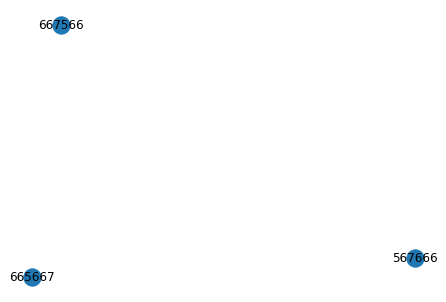

In [284]:
pos=nx.spring_layout(n._g)
nx.draw(n._g, pos=pos)
_ = nx.draw_networkx_labels(n._g, pos=pos, labels=n.get_labels())

In [263]:
[type(_) for _ in nx.connected.connected_components(n._g)]

[set, set, set]

In [262]:
n.get_molecule_similarity((5.0, 7.0, 5.0, 7.0, 5.0, 7.0), (7.0, 5.0, 7.0, 5.0, 7.0, 4.0))

0.8772365810718863

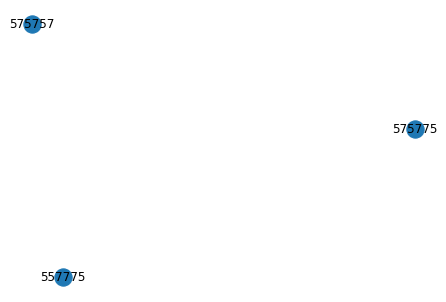

In [280]:
pos=nx.spring_layout(n._g)
nx.draw(n._g, pos=pos)
_ = nx.draw_networkx_labels(n._g, pos=pos, labels=n.get_labels())